Pytorch neural network: FMNIST classification

In [42]:
import numpy as np
import torch
import torch.nn.functional as F 
from torch import optim
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler


# check if CUDA is available
gup_available = torch.cuda.is_available()

if not gup_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


In [43]:
# Data Loader

# Define parameters
n_workers = 0 # for loading data
batch_size= 20
valid_size = 0.2

# Define a transform to normalize the data
transform = transforms.Compose([transforms.RandomRotation(10),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# for FashionMNIST: input datasets.FashionMNIST below
# for cifar: CIFAR10

# Download the training data
trainset = datasets.CIFAR10('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# Download the test data
testset = datasets.CIFAR10('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Set aside validation data
train_indices = list(range(len(trainset)))
np.random.shuffle(train_indices)
split = int(np.floor(len(trainset)*valid_size))
train_idx, valid_idx = train_indices[split:], train_indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Data loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sampler,
                                          batch_size=batch_size)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sampler,
                                          batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


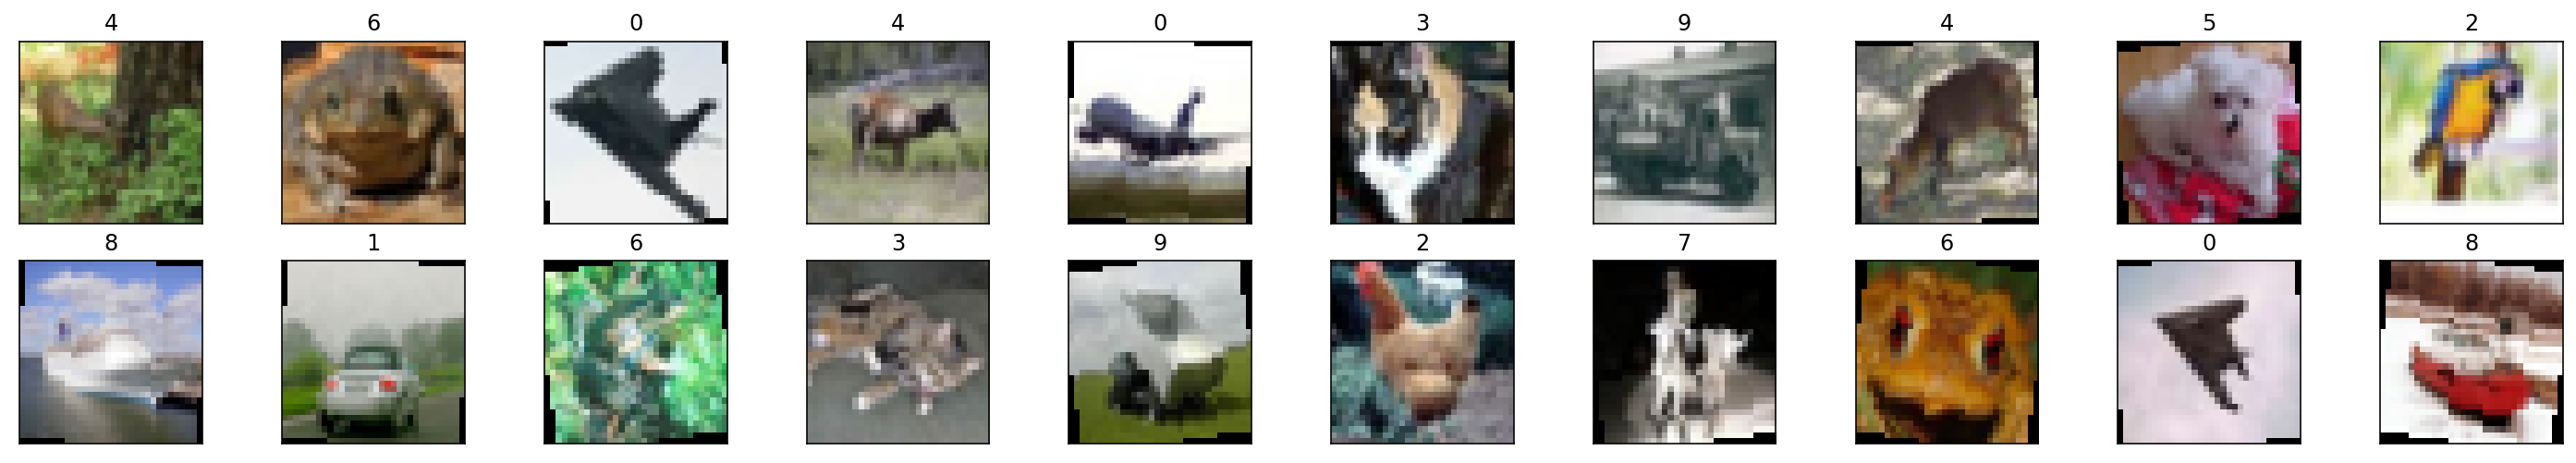

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    #ax.imshow(np.squeeze(images[idx]))
    imshow(images[idx])
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

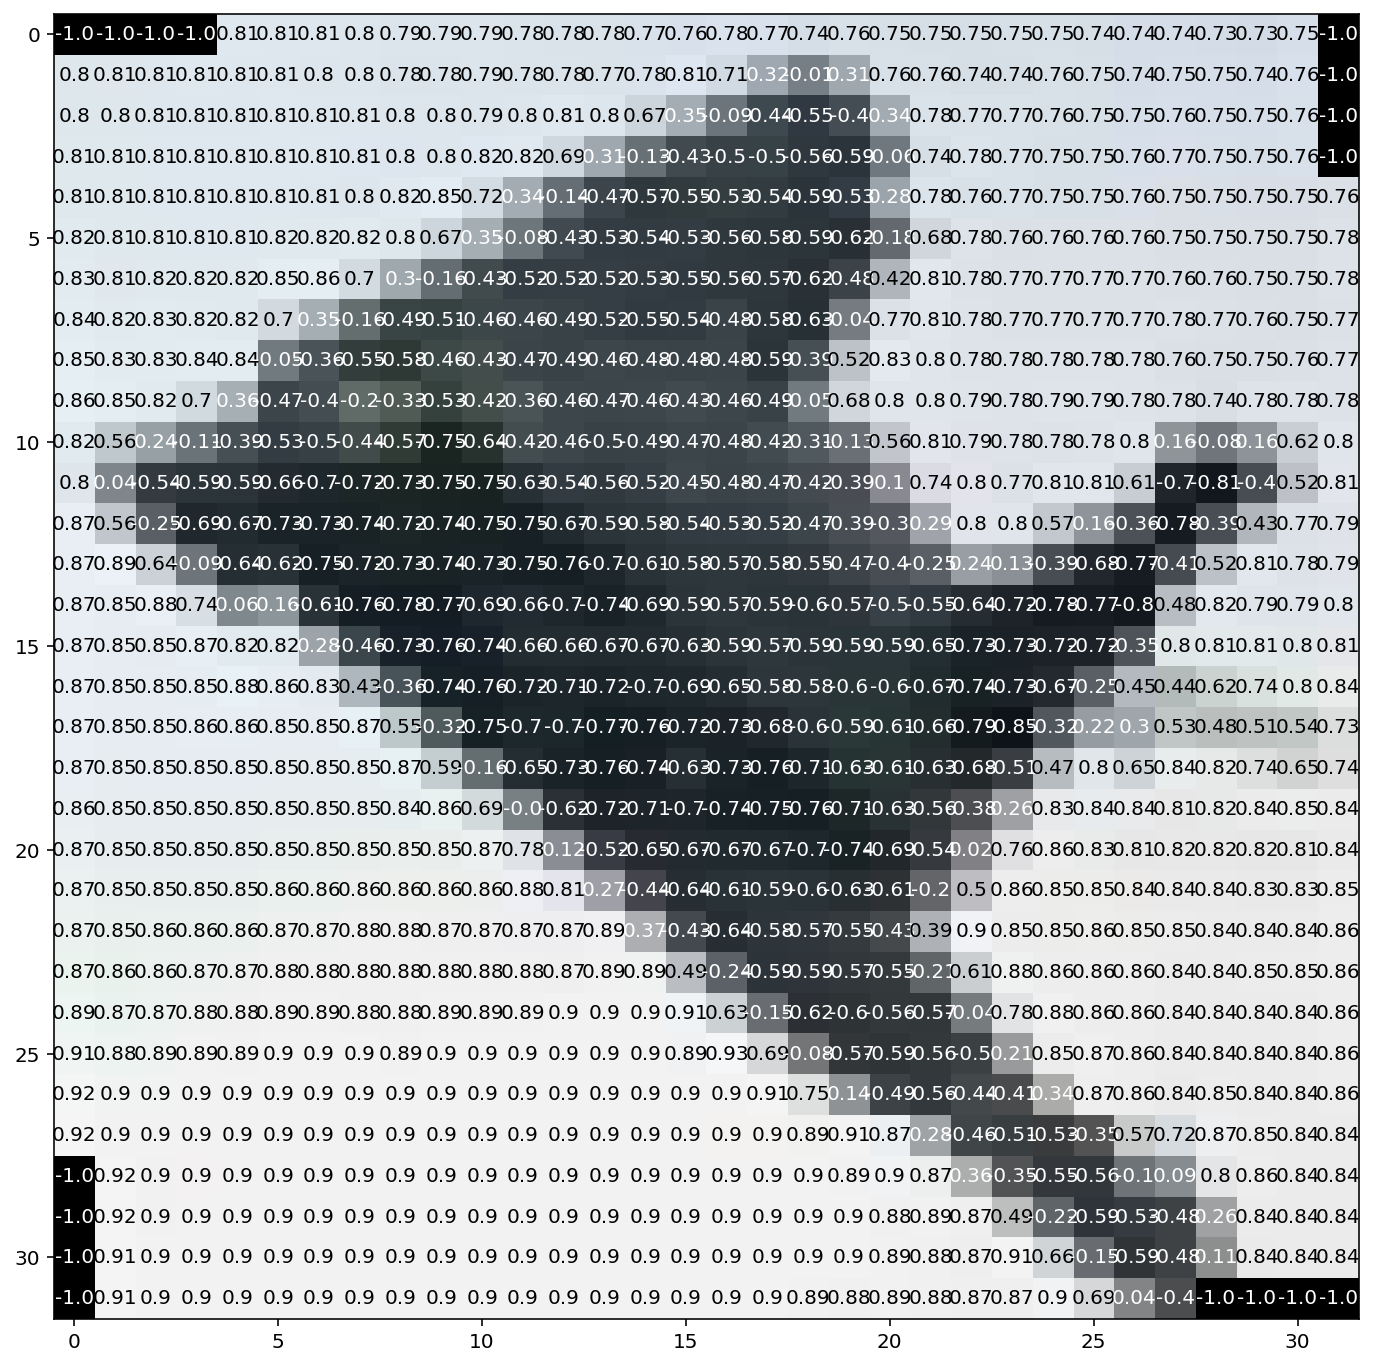

In [58]:
img = np.squeeze(images[2])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
imshow(img)
depth, width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[:,x,y].mean(),2) if img[:,x,y].mean() !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[:,x,y].mean()<thresh else 'black')

In [59]:
class fmnist(nn.Module):
    # Fully connected model
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(784, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.input(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        #x = F.log_softmax(self.output(x), dim=1)
        x = self.output(x)
        
        return x

In [60]:
class fmnist_conv(nn.Module):
    def __init__(self):
        super().__init__()
        # 32,32,3
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
         
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # 7, 7, 32
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) #7,7,64
        
        self.fc1 = nn.Linear(8*8*64, 64)
        self.fc2 = nn.Linear(64,10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x))) #16, 16, 16
        x = F.relu(self.pool(self.conv2(x))) #8, 8, 32
        x = F.relu(self.conv3(x)) #8, 8, 64
        x = self.dropout(F.relu(self.fc1(x.view(-1, 8*8*64))))
        x = self.fc2(x)
        return x

In [61]:
#model = fmnist()
model = fmnist_conv()
if gup_available:
    model = model.cuda()

criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
epochs = 30

valid_loss_min = np.Inf # track change in validation loss
train_losses, test_losses = [], []

for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0 
    accuracy = 0.0
    
    # Train the model
    model.train()
    for images, labels in trainloader:
        #images = images.view(images.shape[0], -1)
        if gup_available:
            images=images.cuda()
            labels=labels.cuda()
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = criteria(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
              
    # Validate the model
    model.eval() # Does not use droupouts
    with torch.no_grad():
        for images, labels in validloader:
            if gup_available:
                images=images.cuda()
                labels=labels.cuda()

            log_ps = model(images)
            valid_loss += criteria(log_ps, labels)
            
            # Calculate the model accuracy
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    train_losses.append(train_loss/len(trainloader))
    test_losses.append(valid_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_loss/len(trainloader)),
          "Test Loss: {:.3f}.. ".format(valid_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1/30..  Training Loss: 1.592..  Test Loss: 1.364..  Test Accuracy: 0.497
Validation loss decreased (inf --> 681.896729).  Saving model ...
Epoch: 2/30..  Training Loss: 1.372..  Test Loss: 1.275..  Test Accuracy: 0.543
Validation loss decreased (681.896729 --> 637.641663).  Saving model ...
Epoch: 3/30..  Training Loss: 1.295..  Test Loss: 1.230..  Test Accuracy: 0.565
Validation loss decreased (637.641663 --> 615.056763).  Saving model ...
Epoch: 4/30..  Training Loss: 1.247..  Test Loss: 1.198..  Test Accuracy: 0.576
Validation loss decreased (615.056763 --> 599.191528).  Saving model ...
Epoch: 5/30..  Training Loss: 1.201..  Test Loss: 1.167..  Test Accuracy: 0.589
Validation loss decreased (599.191528 --> 583.425232).  Saving model ...
Epoch: 6/30..  Training Loss: 1.177..  Test Loss: 1.130..  Test Accuracy: 0.595
Validation loss decreased (583.425232 --> 564.861145).  Saving model ...
Epoch: 7/30..  Training Loss: 1.159..  Test Loss: 1.112..  Test Accuracy: 0.613
Validatio

In [62]:
# Load the best model
model.load_state_dict(torch.load('model_cifar.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

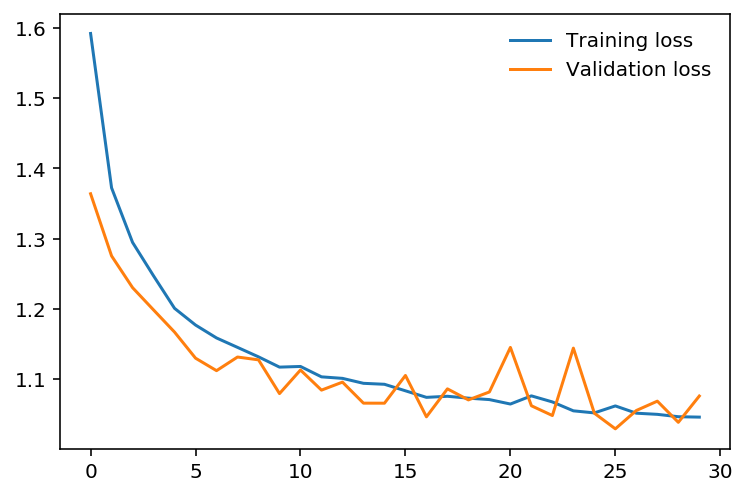

In [63]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Test the model

In [64]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in testloader:
    if gup_available:
        data=data.cuda()
        target=target.cuda()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criteria(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.017641

Test Accuracy of     0: 76% (766/1000)
Test Accuracy of     1: 81% (817/1000)
Test Accuracy of     2: 48% (486/1000)
Test Accuracy of     3: 40% (405/1000)
Test Accuracy of     4: 63% (631/1000)
Test Accuracy of     5: 45% (457/1000)
Test Accuracy of     6: 83% (830/1000)
Test Accuracy of     7: 71% (713/1000)
Test Accuracy of     8: 72% (725/1000)
Test Accuracy of     9: 67% (671/1000)

Test Accuracy (Overall): 65% (6501/10000)


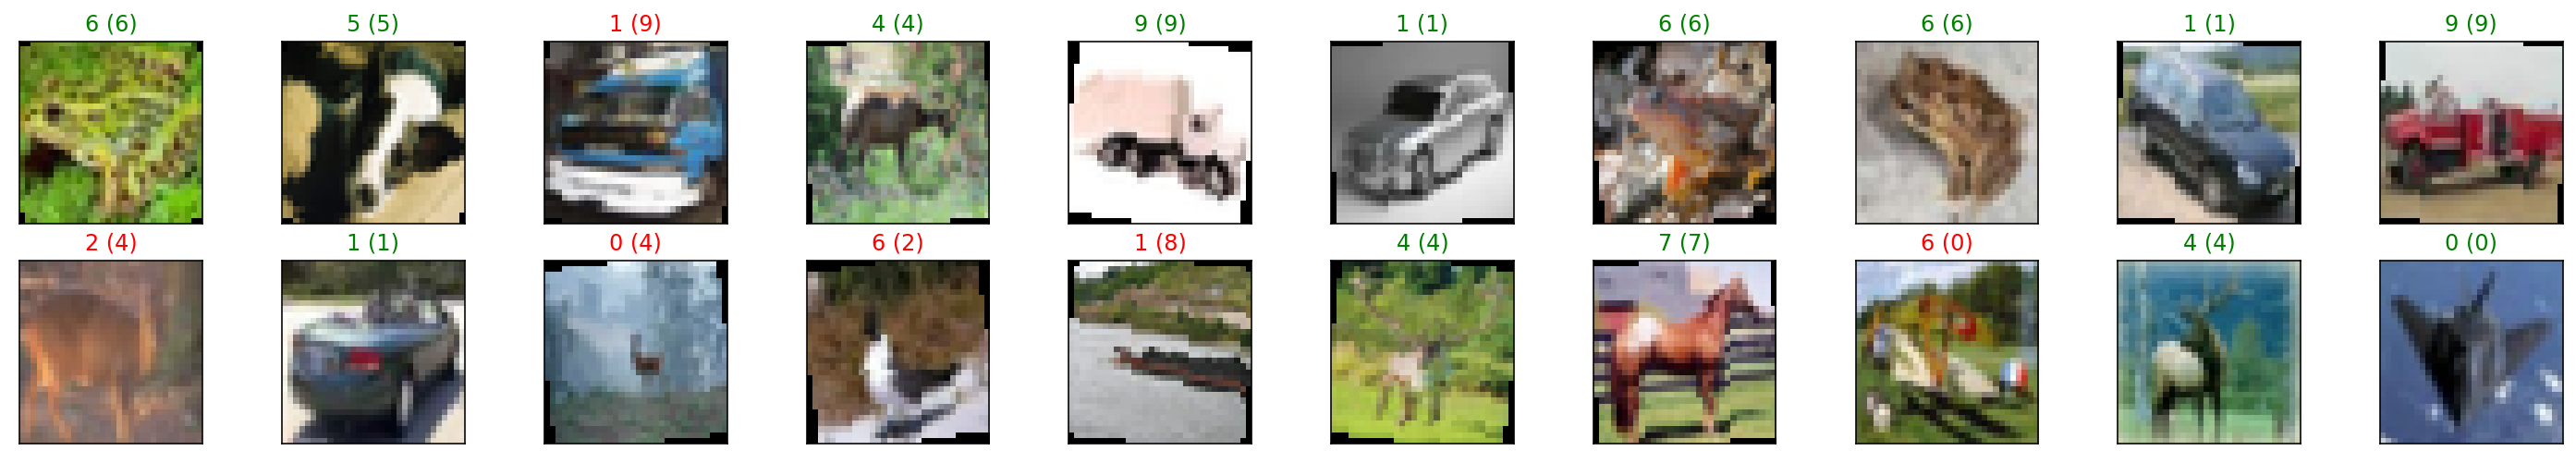

In [65]:
model = model.cpu()
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))